In [14]:
import nengo
import nengo_ocl
import numpy as np
import matplotlib.pyplot as plt
import gym
from nengo.utils.matplotlib import rasterplot

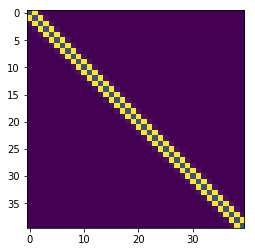

In [64]:
n_actor=40
lateral_sigma = 1
lateral_inhibition = 0.1

lateral_weights = np.zeros((n_actor, n_actor))
for k in range(n_actor):
    for k_p in range(n_actor):
        if k == k_p: continue # no self connection
        lateral_weight = (1+lateral_inhibition)*np.exp(-((k - k_p)/lateral_sigma)**2) - lateral_inhibition
        lateral_weights[k,k_p] = lateral_weight
        
plt.imshow(lateral_weights)

In [54]:
# W = np.arange(15).reshape((3,5))
W = np.random.normal(loc=0.5, scale=0.1, size=(3, 5))
X = np.array([1,1,1,1,1])

np.dot(W,X)

array([2.51168221, 2.5713115 , 2.42747747])

In [59]:
n_place = 100
n_actor = 100
tau_r = 10 # reward time constant
v_k = 30e-3#50e-3
tau_k = 50e-3#200e-3
eps_0 = 10e-3#20e-3
tau_m = 10e-3#20e-3
tau_s = 5e-3
tau_gamma = 50e-3
v_gamma = 20e-3

def get_state(t):
    return np.random.uniform(size=(3))

def outer(t, x):
    X_conv_eps = x[:n_place]
    Y = x[n_place:]
    return np.outer(Y, X_conv_eps).flatten()
    

model = nengo.Network(seed=0)
with model:
    state_node = nengo.Node(get_state)
    place = nengo.Ensemble(n_place,3)
    actor = nengo.Ensemble(n_actor,1)
#     nengo.Connection(state_node, place, solver=nengo.solvers.NoSolver())
    nengo.Connection(state_node, place)
    
    
    actor_outer = nengo.Node(outer,
                            size_in=n_place + n_actor,
                            size_out=n_place * n_actor)
    # convolve place spikes with epsilon
    nengo.Connection(place.neurons,
                     actor_outer[:n_place],
                     synapse=tau_m,
                     transform=((eps_0 * tau_m) / (tau_m - tau_s)))
    nengo.Connection(place.neurons,
                     actor_outer[:n_place],
                     synapse=tau_s,
                     transform=-((eps_0 * tau_s) / (tau_m - tau_s)))
    # Pass raw actor spikes into actor_outer
    nengo.Connection(actor.neurons, actor_outer[n_place:], synapse=None)

    
    yolo = nengo.Node(1000*np.ones(n_actor))
    nengo.Connection(yolo, actor.neurons)
    
    
    action_selection_node = nengo.Node(output=None, size_in=1)
    nengo.Connection(actor,
                     action_selection_node, 
                     synapse=tau_gamma,
                     transform=tau_gamma/(tau_gamma - v_gamma))
    nengo.Connection(actor,
                     action_selection_node,
                     synapse=v_gamma,
                     transform=(-v_gamma)/(tau_gamma - v_gamma))
    
    
    actor_spikes = nengo.Probe(actor.neurons)
    place_spikes = nengo.Probe(place.neurons)
    
sim = nengo.Simulator(model)
with sim:
    sim.run(1)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

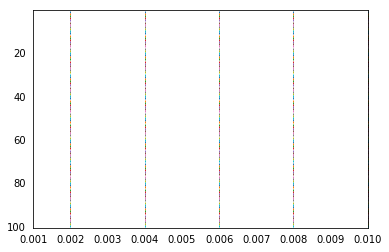

In [60]:
end = 10
rasterplot(sim.trange()[:end], sim.data[actor_spikes][:end])

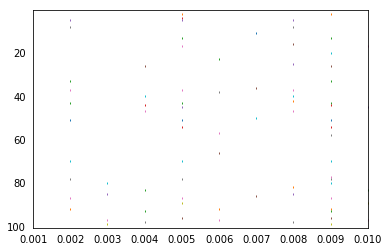

In [58]:
end = 10
rasterplot(sim.trange()[:end], sim.data[place_spikes][:end])

In [ ]:
xs = []
def yolo(t, x):
    xs.append(x)

model = nengo.Network()
with model:
    nd_input = nengo.Node(lambda t: 1 if t % 0.1 == 0 else 0 ,size_out=1)
    td_error_node = nengo.Node(yolo, size_in=1)
#     nengo.Connection(critic.neurons, td_error_node, synapse=None)
    # convolve critic spikes with (K' - K/tau_r)
    nengo.Connection(nd_input,
                     td_error_node,
                     synapse=tau_k,
                     transform=((-tau_r - tau_k)/(tau_r*(tau_k-v_k))))
    nengo.Connection(nd_input,
                     td_error_node,
                     synapse=v_k,
                     transform=((tau_r + v_k)/(tau_r*(tau_k-v_k))))
    
with nengo.Simulator(model) as sim:
    sim.run(5)
    
plt.plot(xs)

In [ ]:
model = nengo.Network()
with model:
    nd_input = nengo.Node(lambda t: 1 if 0.1 < t < 0.4 else 0)
    ens1 = nengo.Ensemble(100,1)
    nengo.Connection(nd_input, ens1, synapse=0.05, transform=-1)
#     nengo.Connection(nd_input, ens1, synapse=0.05, transform=1)
    p0 = nengo.Probe(nd_input)
    p1 = nengo.Probe(ens1)
    p2 = nengo.Probe(ens1.neurons, attr='spikes')
    
dt = 1e-3
T = 0.5
with nengo.Simulator(model, dt=dt) as sim:
    sim.run(T)

ts = np.arange(0,T,dt)
fig, ax = plt.subplots(1,3,figsize=(10,3))
ax[0].plot(ts, sim.data[p0])
ax[0].set_xlabel('t')
ax[0].set_title('Input')
ax[1].plot(ts, sim.data[p1])
ax[1].set_xlabel('t')
ax[1].set_title('First Ensemble')
ax[2].plot(ts, sim.data[p2][:])
ax[2].set_xlabel('t')
ax[2].set_title('Second Ensemble')

plt.tight_layout()

In [ ]:
model = nengo.Network()
with model:
    a = nengo.Ensemble(n_neurons=100, dimensions=1)
    b = nengo.Ensemble(n_neurons=50, dimensions=1)
    
w = 2*np.random.randn(b.n_neurons, a.n_neurons)/b.n_neurons
def my_rule(t, x):
    global w
    output = np.dot(w, x)*0.001
    w += np.random.randn(*w.shape)*0.01   # learning rule
    return output

def test(t,x):
    ensemble_spikes = x[:b.n_neurons]
    learner_spikes = x[b.n_neurons:]
    return np.sum(np.abs(ensemble_spikes - learner_spikes))

with model:
    learner = nengo.Node(my_rule, size_in=a.n_neurons,
                         size_out=b.n_neurons)

    nengo.Connection(a.neurons, learner, synapse=None)
    nengo.Connection(learner, b.neurons, synapse=0.05)
    
    test_node = nengo.Node(test, size_in=2*b.n_neurons)
    nengo.Connection(b.neurons, test_node[:b.n_neurons], synapse=None)
    nengo.Connection(learner, test_node[b.n_neurons:], synapse=None)
    
    test_probe = nengo.Probe(test_node, synapse=None)
    
with nengo.Simulator(model) as sim:
    sim.run(1)
    
plt.plot(sim.data[test_probe])

In [1]:
class LearningEnsemble(object):
    def __init__(self, n_neurons=128, dimensions=4, seed=0):
        self.model = nengo.Network(seed=seed)
        with self.model:
            self.ens = nengo.Ensemble(n_neurons=n_neurons,
                                      dimensions=dimensions,
                                      radius=2)
        self.sim = nengo.Simulator(self.model)
        
        self.w = np.zeros((3, n_neurons))
        
    def forward(self, x):
        _, act = nengo.utils.ensemble.tuning_curves(self.ens, self.sim, inputs=x)
        print(act.shape)
        y = self.w.dot(act)
        return y
    
    def train(self, x, error, learning_rate=1e-4):
        _, act = nengo.utils.ensemble.tuning_curves(self.ens, self.sim, inputs=x)
        
        delta = error.T.dot(act)
        self.w += -learning_rate*delta

e = LearningEnsemble()
e.forward([1,2,3,4])

NameError: name 'nengo' is not defined

In [ ]:
import gym
env = gym.make('Pendulum-v0')
for i_episode in range(2):
    observation = env.reset()
    print(observation)
    for t in range(100):
        env.render()
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        print(action, observation, reward, done, info)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()